In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import numpy as np
import sys
import os
sys.path.append("../")
from sklearn.decomposition import PCA, SparsePCA, FastICA
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.metrics import silhouette_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import time

from contrastive import CPCA
from rpca import R_pca
from supervisedPCA import supervised_pca

In [2]:
# Generate Data
def make_covariances(dims, overlap):
    bg_cov = np.ones((dims, dims))
    fg_cov = np.eye((dims))
    
    return bg_cov, fg_cov

def make_data(fg_cov, bg_cov, n_fg, n_bg, offset, match_noise_level=0.0):
    dims = bg_cov.shape[0]
    bg_data = np.random.multivariate_normal(np.zeros(dims), bg_cov, size=n_bg)# + np.random.multivariate_normal(np.zeros(K), bg_cov, size=n_fg)
    fg_data = bg_data + offset + np.random.multivariate_normal(np.zeros(dims), fg_cov, size=n_fg)
    
    if match_noise_level > 0:
        for i in range(np.min([n_fg, n_bg])):
            if np.random.binomial(1, match_noise_level):
                temp = bg_data[i].copy()
                bg_data[i] = fg_data[i].copy()
                fg_data[i] = temp

    return fg_data, bg_data

def make_diff_data(fg_data, bg_data, n_fg, n_bg, n_unmatched=0):
    diff_matched = np.array([fg_data[i] - bg_data[i] for i in range(n_fg)])
    diff_matched = np.vstack((diff_matched,
                              np.zeros_like(diff_matched))) # Ground vectors.

    if n_unmatched > 0:
        diff_unmatched = np.array([
            fg_data[np.random.choice(n_fg)] - bg_data[np.random.choice(n_bg)] for i in range(n_unmatched)])
        diff_ummatched = np.vstack((diff_unmatched,
                                    np.zeros_like(diff_unmatched)))
        diff_unmatched = np.vstack((diff_matched,
                                 diff_unmatched))
    else:
        diff_unmatched = None
    return diff_matched, diff_unmatched

def get_annotate_loc(ax, data):
    # For plotting.
    if data[np.argmin(data[:, 0]), 1] < data[np.argmax(data[:, 0]), 1]: # angling up
        x_loc = (ax.get_xlim()[1] - ax.get_xlim()[0])*0.7 + ax.get_xlim()[0]
        y_loc = (ax.get_ylim()[1] - ax.get_ylim()[0])*0.1 + ax.get_ylim()[0]
    else:
        x_loc = (ax.get_xlim()[1] - ax.get_xlim()[0])*0.2 + ax.get_xlim()[0]
        y_loc = (ax.get_ylim()[1] - ax.get_ylim()[0])*0.1 + ax.get_ylim()[0]
    return [x_loc, y_loc]

In [3]:
def get_differential(data, numComponents=None, alpha=None):
        """Principal Components Analysis
        Parameters
        ----------
        data : `numpy.ndarray`
            numpy array of data to analyse
        numComponents : `int`
            number of principal components to use

        Returns
        -------
        comps : `numpy.ndarray`
            Principal components
        evals : `numpy.ndarray`
            Eigenvalues
        evecs : `numpy.ndarray`
            Eigenvectors
        """
        
        m, n = data.shape
        #data -= data.mean(axis=0)
        R = np.cov(data, rowvar=False)
        # use 'eigh' rather than 'eig' since R is symmetric,
        # the performance gain is substantial
        evals, evecs = np.linalg.eigh(R)
        idx = np.argsort(evals)[::-1]
        evecs = evecs[:,idx]
        evals = evals[idx]
        if numComponents is not None:
            evecs = evecs[:, :numComponents]
        # carry out the transformation on the data using eigenvectors
        # and return the re-scaled data, eigenvalues, and eigenvectors
        return np.dot(evecs.T, data.T).T, evals, evecs
        """
        if alpha is None:
            alpha = 0.001 / data.shape[0]
        spca = SparsePCA(n_components=numComponents, alpha=0, ridge_alpha=0.1, normalize_components=True)
        data -= np.mean(data, axis=0)
        data /= np.std(data, axis=0)
        spca.fit(data)
        return _, _, spca.components_.T
        """
        

In [15]:
def fit_all(fg_data, bg_data, diff_data_matched, diff_data_unmatched,
            n_reduce_comps=1, n_display_comps=2):
    dimensions = fg_data.shape[1]
    n_fg = fg_data.shape[0]
    n_bg = bg_data.shape[0]
    all_data = np.vstack((fg_data, bg_data))
    all_labels = np.vstack((np.ones((n_fg, 1)), np.zeros((n_bg, 1))))
    
    names = []
    fg_embeddings = []
    bg_embeddings = []
    components = []

    """
    if dimensions == 2:
        names.append("Raw")
        fg_embeddings.append(fg_data)
        bg_embeddings.append(bg_data)
        components.append(np.ones((2, 1)))
    """
    
    """
    # PCA
    pca = PCA(n_components=n_reduce_comps)
    reduced = pca.fit(all_data)
    names.append("PCA")
    fg_embeddings.append(pca.transform(fg_data).dot(pca.components_[:n_display_comps]))
    bg_embeddings.append(pca.transform(bg_data).dot(pca.components_[:n_display_comps]))
    components.append(pca.components_)
    """

    """
    # Contrastive PCA
    mdl = CPCA(n_components=n_components)
    # For some reason, CPCA returns the data as the same size as the input data.
    alpha = 0
    mdl.fit(fg_data, bg_data)
    fg_cpca = mdl.transform(fg_data)[0]
    pca.fit(mdl.fg_cov - alpha*mdl.bg_cov)
    fg_cpca = np.expand_dims(fg_cpca[:, 0], 1).dot(pca.components_)
    bg_cpca = pca.transform(bg_data).dot(pca.components_)
    names.append("cPCA")
    fg_embeddings.append(fg_cpca)
    bg_embeddings.append(bg_cpca)
    """

    """
    # RPCA
    L, S = R_pca(all_data).fit(max_iter=10000, iter_print=1000)
    rpca_components, rpca_evals, rpca_evecs = get_differential(L, n_display_comps)

    fg_rpca = fg_data.dot(rpca_evecs[:, :n_reduce_comps]).dot(
        rpca_evecs[:n_reduce_comps, :n_display_comps])
    bg_rpca = bg_data.dot(rpca_evecs[:, :n_reduce_comps]).dot(
        rpca_evecs[:n_reduce_comps, :n_display_comps])
    names.append("rPCA")
    fg_embeddings.append(fg_rpca)
    bg_embeddings.append(bg_rpca)
    components.append(rpca_evecs[:, 0])
    """
    
    """
    # CCA
    cca = CCA(n_components=n_display_comps, scale=True)
    cca_all_data = np.zeros_like(all_data)
    cca_components = np.zeros((all_data.shape[1], all_data.shape[1]))
    for i in range(n_reduce_comps):
        cca.fit(all_data-cca_all_data, all_labels)
        cca_components[:, i] = cca.x_weights_[:, 0]
        cca_all_data = all_data.dot(cca_components[:, :n_reduce_comps]).dot(
            cca_components[:n_reduce_comps, :])
    cca_all_data = all_data.dot(cca_components[:, :n_reduce_comps]).dot(
        cca_components[:n_reduce_comps, :n_display_comps])
    names.append("CCA")
    fg_embeddings.append(cca_all_data[:n_fg])
    bg_embeddings.append(cca_all_data[n_fg:])
    components.append(cca_components[:, 0])
    """

    """
    # Sparse PCA
    spca = SparsePCA(n_components=n_display_comps, max_iter=1000, verbose=False,
        alpha=10., ridge_alpha=0.0)
    spca.fit(all_data)
    spca_all_data = all_data.dot(spca.components_.T[:, :n_reduce_comps]).dot(
        spca.components_[:n_reduce_comps, :n_display_comps])
    fg_spca = spca_all_data[:n_fg]
    bg_spca = spca_all_data[n_fg:]
    names.append("Sparse PCA")
    fg_embeddings.append(fg_spca)
    bg_embeddings.append(bg_spca)
    components.append(spca.components_.T[:, 0])
    """
    
    """
    # LDA
    lda = LDA(n_components=n_display_comps)
    lda.fit(all_data, all_labels)
    lda_all_data = all_data.dot(lda.scalings_[:, :n_reduce_comps]).dot(
        lda.scalings_.T[:n_reduce_comps, :n_display_comps])
    fg_lda = lda_all_data[:n_fg]
    bg_lda = lda_all_data[n_fg:]
    names.append("LDA")
    fg_embeddings.append(fg_lda)
    bg_embeddings.append(bg_lda)
    components.append(lda.scalings_[:, 0])
    """

    """
    # Supervised PCA
    sup_pca = supervised_pca.SupervisedPCAClassifier(n_components=n_display_comps)
    sup_pca.fit(all_data, all_labels)
    fg_sup_pca = sup_pca.get_transformed_data(fg_data)[:, :n_reduce_comps].dot(
        sup_pca.get_components()[:n_reduce_comps, :])
    bg_sup_pca = sup_pca.get_transformed_data(bg_data)[:, :n_reduce_comps].dot(
        sup_pca.get_components()[:n_reduce_comps, :])
    names.append("Supervised PCA")
    fg_embeddings.append(fg_sup_pca)
    bg_embeddings.append(bg_sup_pca)
    components.append(sup_pca.get_components().T[:, 0])
    """

    # PLSRegression
    plsr = PLSRegression(n_components=n_display_comps, scale=False)
    plsr.fit(all_data, all_labels)
    fg_plsr = plsr.x_scores_[:n_fg, :n_reduce_comps].dot(plsr.x_weights_.T[:n_reduce_comps, :n_display_comps])
    bg_plsr = plsr.x_scores_[n_fg:, :n_reduce_comps].dot(plsr.x_weights_.T[:n_reduce_comps, :n_display_comps])
    names.append("PLS-DA")
    fg_embeddings.append(fg_plsr)
    bg_embeddings.append(bg_plsr)
    components.append(plsr.x_weights_[:, 0])

    # dPCA-Mean
    pca = PCA(n_components=n_display_comps)
    """
    x = np.mean(fg_data, axis=0) - np.mean(bg_data, axis=0)
    x = x.reshape((1, -1))
    pca.fit(np.vstack((x, np.zeros_like(x))))
    dpca_mean_components = pca.components_
    dpca_mean_transformed = pca.transform(all_data)[:, :n_reduce_comps].dot(
        dpca_mean_components[:n_reduce_comps, :n_display_comps])
    names.append("dPCA-Mean")
    fg_embeddings.append(dpca_mean_transformed[:n_fg])
    bg_embeddings.append(dpca_mean_transformed[n_fg:])
    components.append(dpca_mean_components.T[:, 0])
    """

    # dPCA-Matched
    pca.fit(diff_data_matched)
    dpca_components = pca.components_
    dpca_transformed = pca.transform(all_data)[:, :n_reduce_comps].dot(
        dpca_components[:n_reduce_comps, :n_display_comps])
    names.append("dPCA")
    fg_embeddings.append(dpca_transformed[:n_fg])
    bg_embeddings.append(dpca_transformed[n_fg:])
    components.append(dpca_components.T[:, 0])

    """
    # dPCA-Unmatched
    pca.fit(diff_data_unmatched)
    dpca_components = pca.components_
    dpca_transformed = pca.transform(all_data)[:, :n_reduce_comps].dot(
        dpca_components[:n_reduce_comps, :n_display_comps])
    names.append("dPCA-Unmatched")
    fg_embeddings.append(dpca_transformed[:n_fg])
    bg_embeddings.append(dpca_transformed[n_fg:])
    components.append(dpca_components.T[:, 0])
    """

    # drPCA-Matched
    rpca = R_pca(diff_data_matched)
    L, S = rpca.fit(max_iter=1000, iter_print=1000)
    #print(L)
    drpca_components, drpca_evals, drpca_evecs = get_differential(diff_data_matched, n_display_comps)
    reconst_errs = [np.linalg.norm(diff_data_matched -
                              np.expand_dims(diff_data_matched.dot(drpca_evecs[:, i]), 1).dot(np.expand_dims(drpca_evecs.T[i, :], 0)), 2)
                    for i in range(drpca_evecs.shape[1])]
    order = np.argsort(reconst_errs)
    drpca_evecs = np.array([drpca_evecs[:, i] for i in order]).T
    drpca_evecs *= np.abs(drpca_evecs) > 1e-2
    #print(drpca_evecs)
    #drpca_evecs = np.array(sorted(drpca_evecs, key=lambda x: np.linalg.norm(x), reverse=True))
    fg_drpca = fg_data.dot(drpca_evecs[:, :n_reduce_comps]).dot(
        drpca_evecs.T[:n_reduce_comps, :n_display_comps])
    bg_drpca = bg_data.dot(drpca_evecs[:, :n_reduce_comps]).dot(
        drpca_evecs.T[:n_reduce_comps, :n_display_comps])
    names.append("drPCA")
    fg_embeddings.append(fg_drpca)
    bg_embeddings.append(bg_drpca)
    components.append(drpca_evecs[:, 0])

    """
    # drPCA-Unmatched
    rpca = R_pca(diff_data_unmatched)
    L, S = rpca.fit(max_iter=10000, iter_print=1000)
    drpca_components, drpca_evals, drpca_evecs = get_differential(L, n_display_comps)
    reconst_errs = [np.linalg.norm(diff_data_matched -
                              np.expand_dims(diff_data_matched.dot(drpca_evecs[:, i]), 1).dot(np.expand_dims(drpca_evecs.T[i, :], 0)), 2)
                    for i in range(drpca_evecs.shape[1])]
    order = np.argsort(reconst_errs)
    drpca_evecs = np.array([drpca_evecs[:, i] for i in order]).T
    #drpca_evecs = np.array(sorted(drpca_evecs, key=lambda x: np.linalg.norm(x), reverse=True))
    fg_drpca = fg_data.dot(drpca_evecs[:, :n_reduce_comps]).dot(
        drpca_evecs.T[:n_reduce_comps, :n_display_comps])
    bg_drpca = bg_data.dot(drpca_evecs[:, :n_reduce_comps]).dot(
        drpca_evecs.T[:n_reduce_comps, :n_display_comps])
    names.append("drPCA-Unmatched")
    fg_embeddings.append(fg_drpca)
    bg_embeddings.append(bg_drpca)
    components.append(drpca_evecs[:, 0])
    """
    
    """
    # dsPCA-Matched
    spca = SparsePCA(n_components=n_display_comps, max_iter=1000, verbose=False,
        alpha=10., ridge_alpha=0.0)
    spca.fit(diff_data_matched)
    dspca_components = spca.components_
    dspca_all_data = spca.transform(all_data)[:, :n_reduce_comps].dot(
        dspca_components[:n_reduce_comps, :n_display_comps])
    names.append("dsPCA-Matched")
    fg_embeddings.append(dspca_all_data[:n_fg])
    bg_embeddings.append(dspca_all_data[n_fg:])
    components.append(dspca_components.T[:, 0])
    """

    """
    # dsPCA-Unmatched
    spca = SparsePCA(n_components=n_display_comps, max_iter=1000, verbose=False,
        alpha=10., ridge_alpha=0.0)
    spca.fit(diff_data_unmatched)
    dspca_components = spca.components_
    dspca_all_data = spca.transform(all_data)[:, :n_reduce_comps].dot(
        dspca_components[:n_reduce_comps, :n_display_comps])
    names.append("dsPCA-Unmatched")
    fg_embeddings.append(dspca_all_data[:n_fg])
    bg_embeddings.append(dspca_all_data[n_fg:])
    components.append(dspca_components.T[:, 0])
    """
    
    """
    # ICA
    ica = FastICA(n_components=n_display_comps, max_iter=1000)
    ica.fit(all_data)
    names.append("ICA")
    fg_embeddings.append(ica.transform(fg_data)[:, :n_reduce_comps].dot(
        ica.mixing_.T[:n_reduce_comps, :n_display_comps]))
    bg_embeddings.append(ica.transform(bg_data)[:, :n_reduce_comps].dot(
        ica.mixing_.T[:n_reduce_comps, :n_display_comps]))
    components.append(ica.components_.T[:, 0])

    # dICA-Matched
    dica = FastICA(n_components=n_display_comps, max_iter=1000)
    dica.fit(diff_data_matched)
    names.append("dICA-Matched")
    fg_embeddings.append(dica.transform(fg_data)[:, :n_reduce_comps].dot(
        dica.mixing_.T[:n_reduce_comps, :n_display_comps]))
    bg_embeddings.append(dica.transform(bg_data)[:, :n_reduce_comps].dot(
        dica.mixing_.T[:n_reduce_comps, :n_display_comps]))
    components.append(dica.components_.T[:, 0])

    # dICA-Unmatched
    dica = FastICA(n_components=n_display_comps, max_iter=1000)
    dica.fit(diff_data_unmatched)
    names.append("dICA-Unmatched")
    fg_embeddings.append(dica.transform(fg_data)[:, :n_reduce_comps].dot(
        dica.mixing_.T[:n_reduce_comps, :n_display_comps]))
    bg_embeddings.append(dica.transform(bg_data)[:, :n_reduce_comps].dot(
        dica.mixing_.T[:n_reduce_comps, :n_display_comps]))
    components.append(dica.components_.T[:, 0])
    """

    return names, fg_embeddings, bg_embeddings, components

In [16]:
def plot_data(name, fg, bg, my_sil=None):
    fig = plt.figure()
    ax = plt.gca()
    ax.scatter(fg[:, 0], fg[:, 1], marker='*', alpha=0.5)
    ax.scatter(bg[:, 0], bg[:, 1], marker='+', alpha=0.5)
    if my_sil is not None:
        annotate_location = get_annotate_loc(ax, np.vstack((fg, bg)))
        ax.annotate("S: {:.3f}".format(my_sil), annotate_location)
    y_lims = ax.get_ylim()
    x_lims = ax.get_xlim()
    def set_ax_lims(ax):
        y_expand = (y_lims[1] - y_lims[0])*0.05
        x_expand = (x_lims[1] - x_lims[0])*0.05
        ax.set_ylim([y_lims[0] - y_expand, y_lims[1]+y_expand])
        ax.set_xlim([x_lims[0] - x_expand, x_lims[1]+x_expand])
        set_ax_lims(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.savefig("figures/{}.png".format(name))

from scipy.spatial.distance import cosine

def experiment(data_noise_level=0.1, match_noise_level=0.0, dimensions=2, cov_overlap=0.0,
              n_fg=1000, n_bg=1000, annotate_sil=False, n_unmatched=100,
              n_reduce_dim=2, n_display_dim=2, should_plot=True):
    bg_cov, fg_cov = make_covariances(dimensions, cov_overlap)
    #bg_cov[0, 0] = 1
    #bg_cov[1, 1] = 1
    #fg_cov[0, 0] = 0.1
    fg_cov *= data_noise_level
    
    offset = np.zeros((dimensions, ))
    offset[0] = 10
    offset[1] = 4
    offset[2] = 2
    offset[3] = 1.0
    offset[4] = 1.0
    offset[5] = 0.5
    offset[6] = 0.25
    fg_data, bg_data = make_data(fg_cov, bg_cov, n_fg, n_bg, offset,
                                 match_noise_level=match_noise_level)
    diff_data_matched, diff_data_unmatched = make_diff_data(fg_data, bg_data,
                                                            n_fg, n_bg, n_unmatched)
    if dimensions == 2:
        plt.scatter(diff_data_matched[:, 0], diff_data_matched[:, 1])
    #else:
    #    p = PCA(n_components=2)
    #    p.fit(np.vstack((fg_data, bg_data)))
    #    plt.scatter(p.)
    
    measure_silhouette = lambda reps: silhouette_score(reps,
        np.ravel(np.vstack((np.ones((n_fg, 1)), np.zeros((n_bg, 1))))))
    
    names, fg_embeddings, bg_embeddings, components = fit_all(fg_data, bg_data,
                                                          diff_data_matched,
                                                          diff_data_unmatched,
                                                          n_reduce_dim,
                                                          n_display_dim)
    #plot_data("Raw", fg_data, bg_data,
    #          measure_silhouette(np.vstack((fg_data, bg_data))))
    cosines = []
    print("Model & Silhouette Scores \\\\")
    for name, fg, bg, comps in zip(names, fg_embeddings, bg_embeddings, components):
        my_sil = measure_silhouette(np.vstack((fg, bg)))
        if len(comps.shape) > 1:
            comps = comps[0]
        my_cosine = cosine(np.abs(comps), np.abs(offset))
        cosines.append(my_cosine)
        print("{} & {:.3f} & {:.6f} \\\\".format(name, my_sil, my_cosine))
        if should_plot:
            plot_data(name, fg, bg, my_sil)
    return cosines, names

0 16
iteration: 1, error: 0.5627872094277996
iteration: 3, error: 0.00014499619706604113
Model & Silhouette Scores \\
PLS-DA & 0.894 & 0.002467 \\
dPCA & 0.894 & 0.002468 \\
drPCA & 0.882 & 0.000010 \\
0 32
iteration: 1, error: 1.1554778823971485
iteration: 3, error: 0.00032579803204348513
Model & Silhouette Scores \\
PLS-DA & 0.848 & 0.001304 \\
dPCA & 0.848 & 0.001304 \\
drPCA & 0.851 & 0.000008 \\
0 64
iteration: 1, error: 2.2913752851087112
iteration: 3, error: 0.000692218822875771
Model & Silhouette Scores \\
PLS-DA & 0.807 & 0.000626 \\
dPCA & 0.807 & 0.000627 \\
drPCA & 0.806 & 0.000001 \\
0 128
iteration: 1, error: 4.640204341521084
iteration: 3, error: 0.00150664448398856
Model & Silhouette Scores \\
PLS-DA & 0.831 & 0.000305 \\
dPCA & 0.831 & 0.000305 \\
drPCA & 0.835 & 0.000002 \\
0 256
iteration: 1, error: 9.262484452744632
iteration: 4, error: 0.0031189710969463515
Model & Silhouette Scores \\
PLS-DA & 0.810 & 0.000157 \\
dPCA & 0.810 & 0.000157 \\
drPCA & 0.813 & 0.000002

iteration: 1, error: 177.16214035084556
iteration: 77, error: 0.037086789801590705
Model & Silhouette Scores \\
PLS-DA & 0.819 & 0.001078 \\
dPCA & 0.819 & 0.001081 \\
drPCA & 0.819 & 0.000002 \\
0 16
iteration: 1, error: 12.787253875124375
iteration: 34, error: 0.0010076161683105814
Model & Silhouette Scores \\
PLS-DA & 0.904 & 0.115083 \\
dPCA & 0.877 & 0.120829 \\
drPCA & 0.872 & 0.115094 \\
0 32
iteration: 1, error: 25.357312529127814
iteration: 28, error: 0.001967918770770692
Model & Silhouette Scores \\
PLS-DA & 0.856 & 0.056145 \\
dPCA & 0.860 & 0.056281 \\
drPCA & 0.867 & 0.046426 \\
0 64
iteration: 1, error: 51.464032849917686
iteration: 32, error: 0.003968753344506328
Model & Silhouette Scores \\
PLS-DA & 0.848 & 0.030733 \\
dPCA & 0.848 & 0.031671 \\
drPCA & 0.834 & 0.021163 \\
0 128
iteration: 1, error: 101.33421934300203
iteration: 43, error: 0.00784541989323203
Model & Silhouette Scores \\
PLS-DA & 0.859 & 0.016188 \\
dPCA & 0.857 & 0.016227 \\
drPCA & 0.835 & 0.005957 \\

iteration: 1, error: 7194.858938136152
iteration: 64, error: 0.12827051845020046
Model & Silhouette Scores \\
PLS-DA & 0.779 & 0.018934 \\
dPCA & 0.769 & 0.020111 \\
drPCA & 0.780 & 0.010151 \\
1 1024
iteration: 1, error: 8747.288053945123
iteration: 75, error: 0.26424286956650445
Model & Silhouette Scores \\
PLS-DA & 0.794 & 0.009936 \\
dPCA & 0.795 & 0.010720 \\
drPCA & 0.789 & 0.001969 \\


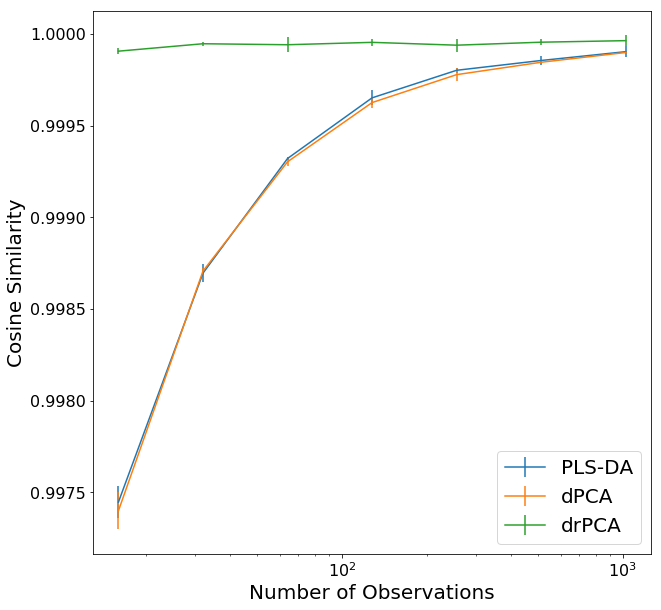

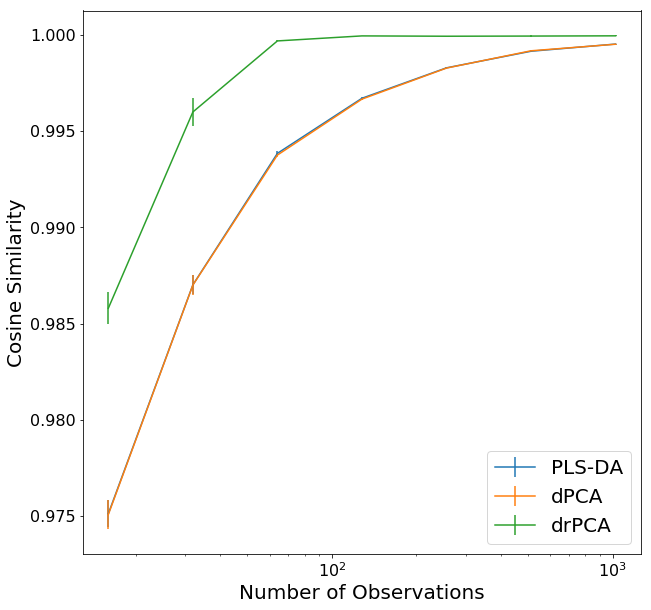

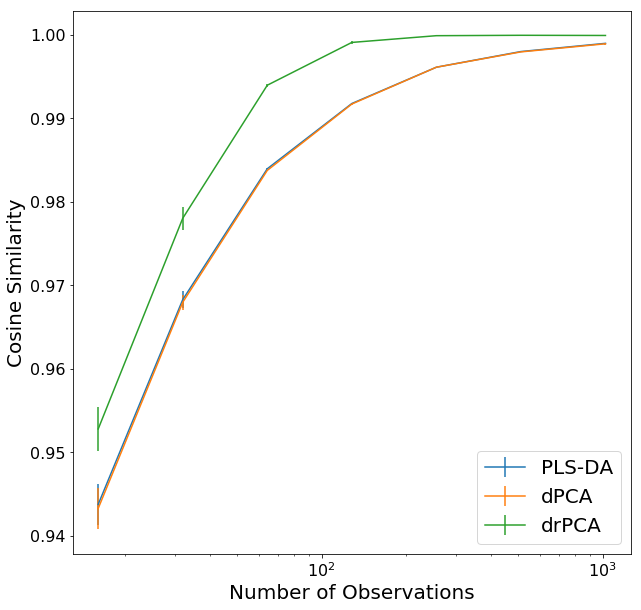

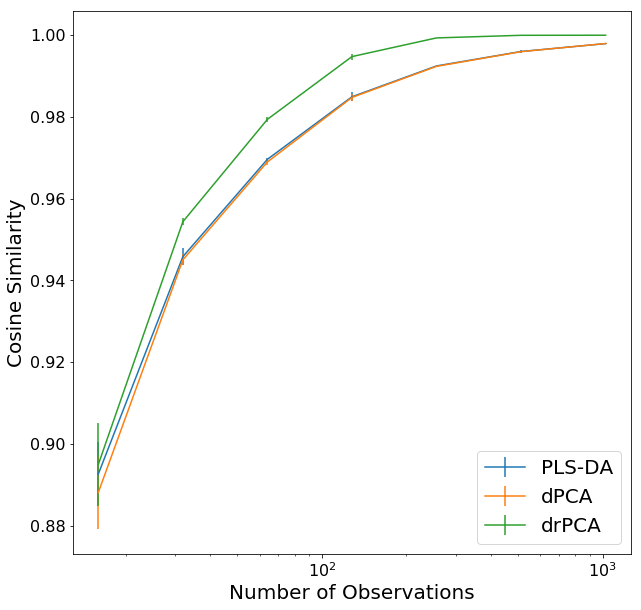

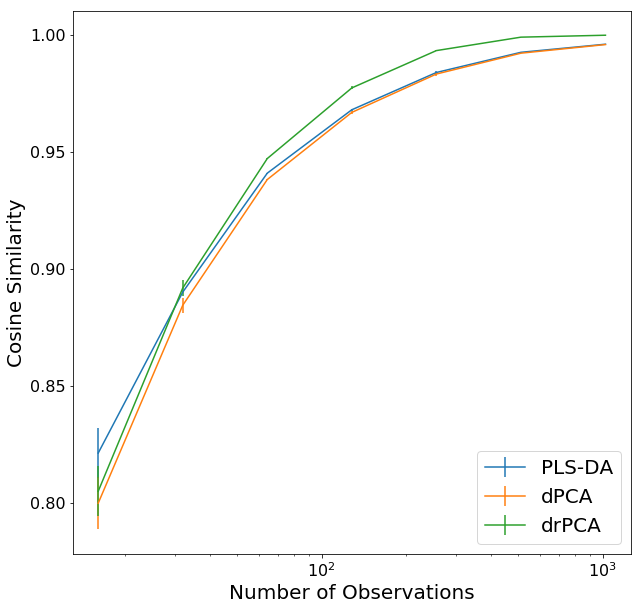

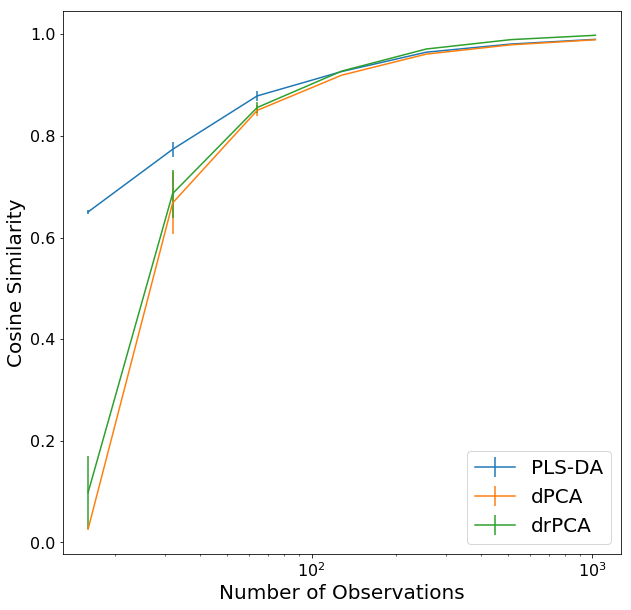

In [17]:
for noise_level in [0.01, 0.1, 0.25, 0.5, 1.0, 2.5]:
    all_results = []
    for i in range(2):
        cosines = []
        ns = [16, 32, 64, 128, 256, 512, 1024]
        for n in ns:
            print(i, n)
            cos, names = experiment(dimensions=1000, n_reduce_dim=1, data_noise_level=noise_level,
                           n_fg=n, n_bg=n, should_plot=False)
            cosines.append(cos)
        cosines = 1. - np.abs(np.array(cosines).T)
        cosines -= np.random.uniform(0., 0.0001, size=cosines.shape)
        all_results.append(cosines)
    all_results = np.array(all_results)

    fig = plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_xscale("log", nonposx='clip')
    ax.tick_params(labelsize=16)
    for i, name in enumerate(names):
        results = all_results[:, i]
        plt.errorbar(ns, np.mean(results, axis=0), yerr=np.std(results, axis=0), label=name)
    plt.ylabel("Cosine Similarity", fontsize=20)
    plt.xlabel("Number of Observations", fontsize=20)
    lgd = plt.legend(loc='lower right', fontsize=20)#, bbox_to_anchor=(1, 0.5))
    plt.savefig("simulation_{:.3f}.png".format(noise_level), dpi=300, bbox_extra_artists=[lgd], bbox_inches='tight')